# We can also perform Bayesian Inference with JAX

In this particular problem, we can see how we can use Langevin dynamics to sample from a Bayesian formulated problem. In Bayesian inference, estimates are derived in 3 steps:
1) Assume a prior
2) Calculate the likelihood times the prior to get the proportional posterior
3) Sample from the proportional posterior (either by normalizing or by using methods invariant to proportionality), then take the mean

We will adopt the same method, but in (3), we use Langevin dynamics, which rely on the score of the proportional likelihood, as well as the gradient. Consider the following problem as specified in the neural network notebook.

In [163]:
import jax 
from jax import random as jnr
import jax.numpy as jnp 

key = jnr.PRNGKey(42)
b0, b1, b2 = jnr.randint(key, shape = (3,), minval=-5, maxval=5)

s = jnr.gamma(key, a=4)

X1_key, X2_key = jnr.split(key)
X0 = jnp.ones((1000, 1))
X1 = jnr.normal(X1_key, (1000, 1))
X2 = jnr.normal(X2_key, (1000, 1))
X = jnp.hstack([X0, X1, X2])
y = b1*X1 + b2*X2 + b0 + jnp.sqrt(s)*jnr.normal(key, (1000, 1))

We hide the true values by asking JAX to generate the values randomly. The coefficients are generated from a Uniform(-5, 5) distribution and the variance $s$ is from a Gamma(4, 1) distribution. Conveniently, let these distributions be our priors.

So our prior is of the form:

$\pi(\beta_0, \beta_1, \beta_2, s) \propto s^3e^{-s} \times \mathbf{1}(\{\beta_0, \beta_1, \beta_2\} \in (-5, 5))$

Our likelihood in a linear regression is simply:

$\mathbf{P}(Y|X;\beta_0, \beta_1, \beta_2, s) = \left(\frac{1}{\sqrt{2\pi s}}\right)^n \exp\left(-\frac{\sum_{i=1}^n (y_i - \beta_0 - \beta_1 x_{1i} - \beta_2 x_{2i})^2}{2s}\right)$

So our posterior is proportional to:

$p(\beta_0, \beta_1, \beta_2, s \vert x, y) \propto s^3e^{-s} \times \mathbf{1}(\{\beta_0, \beta_1, \beta_2\} \in (-5, 5)) \times \left(\frac{1}{\sqrt{s}}\right)^n \exp\left(-\frac{\sum_{i=1}^n(y_i - \beta_0 - \beta_1 x_{1i} - \beta_2 x_{2i})^2}{2s}\right) $


In [164]:
from jax import grad

def logLik(b0, b1, b2, s):
    n = X.shape[0]
    variance_prior = 3 * jnp.log(s) - s 
    beta_prior = lambda b: jnp.log(1/25) if -5 <= b <= 5 else -jnp.inf
    likelihood = (-n/2) * jnp.log(s) - jnp.sum((y- X0 * b0 - X1 * b1 - X2 * b2)**2) / (2 *s)
    return variance_prior + beta_prior(b0) + beta_prior(b1) + beta_prior(b2) + likelihood

score = grad(logLik, (0,1,2,3))

In Langevin dynamics, we have 

$dX_t = \nabla \log p(x) + \sqrt{2}\sigma dW_t$

And its approximate solution with Euler Maruyama discretization is:

$X_{t+1} = X_{t} + \nabla_x \log p(x) \varepsilon + \sqrt{2\varepsilon} z_t$

In our case, $X_t$ will be a vector of $\beta_0,...,\beta_2, s$ and $z_t$ is sampled from the standard normal. Thus after we get the chain of $X_t$, we can treat it as a MCMC and take the means to get the posterior estimates.

In [196]:
xt = jnp.array([1.0, 3.0, 2.0, 6.0])
estimates = [xt]
lr = 0.001
z = jnr.normal(key, shape=(10000,4))
idx = 0
while idx < 10000:
    xt = xt + jnp.array(score(xt[0], xt[1], xt[2], xt[3])) * lr + jnp.sqrt(2*lr) * z[idx]
    xt = jnp.array([jnp.clip(xt[0], -5, 5), jnp.clip(xt[1], -5, 5), jnp.clip(xt[2], -5, 5), xt[3]])
    estimates.append(xt)
    idx += 1
estimates = jnp.vstack(estimates)

In [197]:
posteriors = estimates[5000:,:]
b_estimates = posteriors.mean(axis=0)
print(b_estimates)

[-0.09248736  2.9724617   2.0080993  10.237037  ]


We can grab our estimates by taking a burn in, and taking the sample mean of what is remaining. Here we burn in the first 5000 observations, and we look at the remaining 5000 to form our posterior. Essentially, we have marginalized and taken the mean of the joint posterior space. Lets compare that with our ground truths. We should expect them to be similar to our estimates since we have 1000 data points of observations. We observe this to be true in our Bayesian estimates. 

In [198]:
print(f'Truth) b0: {b0}, b1: {b1}, b2: {b2}, var: {s}')
print(f'Bayes) b0: {b_estimates[0]}, b1: {b_estimates[1]}, b2: {b_estimates[2]}, var: {b_estimates[3]}')
print(f'Diff) b0: {b0 - b_estimates[0]}, b1: {b1 - b_estimates[1]}, b2: {b2 - b_estimates[2]}, var: {s - b_estimates[3]}')

Truth) b0: 0, b1: 3, b2: 2, var: 10.001626014709473
Bayes) b0: -0.09248735755681992, b1: 2.972461700439453, b2: 2.008099317550659, var: 10.23703670501709
Diff) b0: 0.09248735755681992, b1: 0.027538299560546875, b2: -0.00809931755065918, var: -0.2354106903076172


As with Bayesian inference, we can also look at credible intervals. From below, we can see that they cover our true parameters. The interpretation of the credible interval is a little more intuitive. The probability that $\beta_0$ lies between -0.29 and 0.11 is 95 percent. We can make the same arguments about the other parameters since each parameter is considered a random variable in the Bayesian framework.

In [203]:
b0_cred_int = jnp.quantile(posteriors[:, 0], jnp.array([0.025, 0.975])).tolist()
b1_cred_int = jnp.quantile(posteriors[:, 1], jnp.array([0.025, 0.975])).tolist()
b2_cred_int = jnp.quantile(posteriors[:, 2], jnp.array([0.025, 0.975])).tolist()
s_cred_int = jnp.quantile(posteriors[:, 3], jnp.array([0.025, 0.975])).tolist()
print(f'b0 credible interval: {b0_cred_int}')
print(f'b1 credible interval: {b1_cred_int}')
print(f'b2 credible interval: {b2_cred_int}')
print(f's credible interval: {s_cred_int}')

b0 credible interval: [-0.2913048267364502, 0.11071795970201492]
b1 credible interval: [2.7751481533050537, 3.1816694736480713]
b2 credible interval: [1.8196102380752563, 2.2109415531158447]
s credible interval: [9.34976577758789, 11.153777122497559]


We can also view the marginal distributions of each posterior parameter.

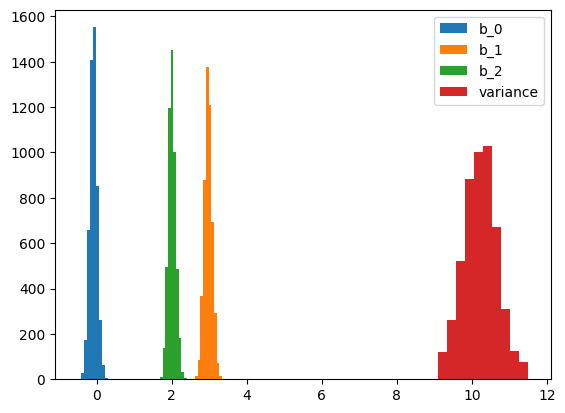

In [208]:
import matplotlib.pyplot as plt
plt.hist(posteriors[:, 0], label='b_0')
plt.hist(posteriors[:, 1], label='b_1')
plt.hist(posteriors[:, 2], label='b_2')
plt.hist(posteriors[:, 3], label='variance')
plt.legend()

The chain does not look to be stationary, especially for the variance parameter. One alternative is to perform a Metropolis Hastings type of accept and rejection to induce some stationarity.

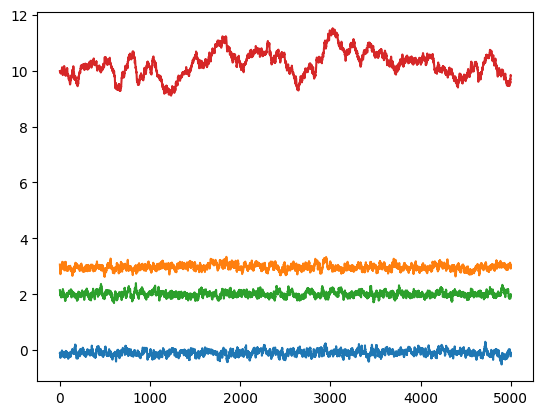

In [211]:
plt.plot(posteriors[:,0])
plt.plot(posteriors[:,1])
plt.plot(posteriors[:,2])
plt.plot(posteriors[:,3])